# **E1-201 : Hardware Acceleration on Machine Learning**
---
## **Course Project :**
### **Implementation of Brain Computer Interface(BCI) Decoder using Arduino Nano 33 BLE sense Lite**
---
**Authors :**
1. Hitesh Pavan Oleti (SR.No.:19804, ESE, IISc)
2. Anand Chauhan      (SR.No.:*****, ESE, IISc)

**Submitted to :**

Prof. Chetan Singh Thakur,

NeuRonICS Lab, IISc.

---

**TensorFlow Version**

In [ ]:
import tensorflow as tf
tf.print(tf.__version__)

2.9.2


**Installing MNE Package**

(An open-source Python package for exploring, visualizing, and analyzing human neurophysiological data: MEG, EEG, sEEG, ECoG and NIRS)

In [ ]:
!pip install mne

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Importing Libraries**

In [ ]:
import numpy as np

# mne imports
import mne
from mne import io
from mne.datasets import sample

# EEGNet-specific imports
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K

# tools for plotting confusion matrices
from matplotlib import pyplot as plt

**Mounting Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

## **EEGNet Model**

In [ ]:
def EEGNet(nb_classes, Chans = 64, Samples = 128, 
             dropoutRate = 0.5, kernLength = 64, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
    """ Keras Implementation of EEGNet
    http://iopscience.iop.org/article/10.1088/1741-2552/aace8c/meta
    Note that this implements the newest version of EEGNet and NOT the earlier
    version (version v1 and v2 on arxiv). We strongly recommend using this
    architecture as it performs much better and has nicer properties than
    our earlier version. For example:
        
        1. Depthwise Convolutions to learn spatial filters within a 
        temporal convolution. The use of the depth_multiplier option maps 
        exactly to the number of spatial filters learned within a temporal
        filter. This matches the setup of algorithms like FBCSP which learn 
        spatial filters within each filter in a filter-bank. This also limits 
        the number of free parameters to fit when compared to a fully-connected
        convolution. 
        
        2. Separable Convolutions to learn how to optimally combine spatial
        filters across temporal bands. Separable Convolutions are Depthwise
        Convolutions followed by (1x1) Pointwise Convolutions. 
        
    
    While the original paper used Dropout, we found that SpatialDropout2D 
    sometimes produced slightly better results for classification of ERP 
    signals. However, SpatialDropout2D significantly reduced performance 
    on the Oscillatory dataset (SMR, BCI-IV Dataset 2A). We recommend using
    the default Dropout in most cases.
        
    Assumes the input signal is sampled at 128Hz. If you want to use this model
    for any other sampling rate you will need to modify the lengths of temporal
    kernels and average pooling size in blocks 1 and 2 as needed (double the 
    kernel lengths for double the sampling rate, etc). Note that we haven't 
    tested the model performance with this rule so this may not work well. 
    
    The model with default parameters gives the EEGNet-8,2 model as discussed
    in the paper. This model should do pretty well in general, although it is
	advised to do some model searching to get optimal performance on your
	particular dataset.
    We set F2 = F1 * D (number of input filters = number of output filters) for
    the SeparableConv2D layer. We haven't extensively tested other values of this
    parameter (say, F2 < F1 * D for compressed learning, and F2 > F1 * D for
    overcomplete). We believe the main parameters to focus on are F1 and D. 
    Inputs:
        
      nb_classes      : int, number of classes to classify
      Chans, Samples  : number of channels and time points in the EEG data
      dropoutRate     : dropout fraction
      kernLength      : length of temporal convolution in first layer. We found
                        that setting this to be half the sampling rate worked
                        well in practice. For the SMR dataset in particular
                        since the data was high-passed at 4Hz we used a kernel
                        length of 32.     
      F1, F2          : number of temporal filters (F1) and number of pointwise
                        filters (F2) to learn. Default: F1 = 8, F2 = F1 * D. 
      D               : number of spatial filters to learn within each temporal
                        convolution. Default: D = 2
      dropoutType     : Either SpatialDropout2D or Dropout, passed as a string.
    """
    
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input1   = Input(shape = (Chans, Samples, 1))

    ##################################################################
    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (Chans, Samples, 1),
                                   use_bias = False)(input1)
    block1       = BatchNormalization()(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False, 
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization()(block1)
    block1       = Activation('relu')(block1)
    block1       = AveragePooling2D((1, 4))(block1)
    block1       = dropoutType(dropoutRate)(block1)
    
    block2       = SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization()(block2)
    block2       = Activation('relu')(block2)
    block2       = AveragePooling2D((1, 8))(block2)
    block2       = dropoutType(dropoutRate)(block2)
        
    flatten      = Flatten(name = 'flatten')(block2)
    
    dense        = Dense(nb_classes, name = 'dense', 
                         kernel_constraint = max_norm(norm_rate))(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)
    
    return Model(inputs=input1, outputs=softmax)

**Loading Input Dataset**

In [ ]:
from pandas import read_csv
import pandas as pd
EPOC_dataset = read_csv('/content/gdrive/MyDrive/HAOML project/mne_iir_elliptic_5thorder.csv')
EPOC_dataset = EPOC_dataset.values
display(pd.DataFrame(EPOC_dataset))
chans = 60; samples = 151;
row, col = EPOC_dataset.shape

y =  EPOC_dataset[:,col-1]
X = np.zeros([row,chans,samples])
for i in range(row):
  X[i,:,:] = np.reshape(EPOC_dataset[i,0:col-1],(chans,samples))

print(X.shape)
print(y.shape)

,0,1,2,3,4,5,6,7,8,9,...,9051,9052,9053,9054,9055,9056,9057,9058,9059,9060
0,-0.006216,-0.002473,-0.001460,0.000278,0.002166,-0.000691,-0.005169,-0.000554,0.011705,0.015283,...,-0.000588,-0.002020,-0.002192,-0.002092,-0.001955,-0.000659,0.000963,0.000479,-0.001698,3.0
1,-0.013908,-0.001546,0.003924,0.002744,-0.000030,-0.000442,0.001255,0.003638,0.007079,0.010767,...,-0.001095,0.003595,0.006555,0.009162,0.009595,0.007354,0.005818,0.005819,0.003452,1.0
2,-0.009865,-0.008093,-0.000416,0.007732,0.006604,0.001789,0.004578,0.011065,0.009254,-0.000050,...,-0.009036,-0.011451,-0.012151,-0.009407,-0.005621,-0.003849,-0.002715,0.001215,0.007001,4.0
3,-0.021735,-0.004651,0.004099,0.005067,0.004111,0.004046,0.004371,0.004783,0.004688,0.003471,...,-0.002036,-0.002812,-0.002126,-0.000408,0.002377,0.004493,0.004046,0.002502,0.002879,2.0
4,0.004510,0.001443,-0.003337,-0.004331,-0.003892,-0.004020,-0.001465,0.003807,0.005183,0.001069,...,-0.009972,-0.004302,0.000416,0.004141,0.005437,0.004721,0.004818,0.006758,0.008330,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282,0.005864,-0.004179,-0.001315,0.006821,-0.000653,-0.014626,-0.008492,0.012965,0.017966,0.000361,...,-0.002424,-0.002267,-0.004446,-0.005083,-0.003439,-0.002352,-0.002922,-0.003316,-0.002525,4.0
283,0.004587,0.001885,-0.004905,-0.006425,-0.002929,-0.001749,-0.004911,-0.003857,0.007078,0.017092,...,-0.001034,-0.002224,-0.002893,-0.000772,0.003160,0.005563,0.005493,0.004522,0.003104,2.0
284,-0.007533,-0.000786,0.005859,0.006119,0.001304,-0.002044,-0.004138,-0.007412,-0.006266,0.002945,...,-0.000488,-0.000299,0.001258,0.003975,0.005977,0.004637,-0.000201,-0.004684,-0.004382,3.0
285,-0.011000,-0.002675,0.003632,0.006324,0.003787,-0.001937,-0.002754,0.004395,0.010109,0.006383,...,-0.002402,-0.003627,-0.003759,-0.001958,0.000874,0.003127,0.003313,0.001040,-0.001837,1.0


(287, 60, 151)
(287,)


**Train, Validation and Test split**

In [ ]:
kernels, chans, samples = 1, 60, 151

# take 50/25/25 percent of the data to train/validate/test
X_train      = X[0:144,]
Y_train      = y[0:144]
X_validate   = X[144:216,]
Y_validate   = y[144:216]
X_test       = X[216:,]
Y_test       = y[216:]


## **EEGNet model training**

In [ ]:
############################# EEGNet portion ##################################

# convert labels to one-hot encodings.
Y_train      = np_utils.to_categorical(Y_train-1)
Y_validate   = np_utils.to_categorical(Y_validate-1)
Y_test       = np_utils.to_categorical(Y_test-1)
print(Y_train.shape, 'train samples Y')
print(Y_test.shape, 'test samples Y')


# convert data to NHWC (trials, channels, samples, kernels) format. Data 
# contains 60 channels and 151 time-points. Set the number of kernels to 1.
X_train      = X_train.reshape(X_train.shape[0], chans, samples, kernels)
X_validate   = X_validate.reshape(X_validate.shape[0], chans, samples, kernels)
X_test       = X_test.reshape(X_test.shape[0], chans, samples, kernels)
   
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# configure the EEGNet-8,2,16 model with kernel length of 32 samples (other 
# model configurations may do better, but this is a good starting point)
model = EEGNet(nb_classes = 4, Chans = chans, Samples = samples, 
               dropoutRate = 0.5, kernLength = 32, F1 = 8, D = 2, F2 = 16, 
               dropoutType = 'Dropout')

# compile the model and set the optimizers
model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics = ['accuracy'])

# count number of parameters in the model
numParams    = model.count_params()    

# set a valid path for your system to record model checkpoints
checkpointer = ModelCheckpoint(filepath='/tmp/checkpoint.h5', verbose=1,
                               save_best_only=True)

class_weights = {0:1, 1:1, 2:1, 3:1}

################################################################################
# fit the model. Due to very small sample sizes this can get
# pretty noisy run-to-run, but most runs should be comparable to xDAWN + 
# Riemannian geometry classification (below)
################################################################################
fittedModel = model.fit(X_train, Y_train, batch_size = 16, epochs = 300, 
                        verbose = 2, validation_data=(X_validate, Y_validate),
                        callbacks=[checkpointer], )#class_weight = class_weights)

# load optimal weights
model.load_weights('/tmp/checkpoint.h5')

(144, 4) train samples Y
(71, 4) test samples Y
X_train shape: (144, 60, 151, 1)
144 train samples
71 test samples
Epoch 1/300

Epoch 1: val_loss improved from inf to 1.38632, saving model to /tmp/checkpoint.h5
9/9 - 3s - loss: 1.4352 - accuracy: 0.1875 - val_loss: 1.3863 - val_accuracy: 0.2500 - 3s/epoch - 309ms/step
Epoch 2/300

Epoch 2: val_loss did not improve from 1.38632
9/9 - 1s - loss: 1.3820 - accuracy: 0.2708 - val_loss: 1.3863 - val_accuracy: 0.2361 - 1s/epoch - 153ms/step
Epoch 3/300

Epoch 3: val_loss improved from 1.38632 to 1.38632, saving model to /tmp/checkpoint.h5
9/9 - 1s - loss: 1.3874 - accuracy: 0.2847 - val_loss: 1.3863 - val_accuracy: 0.2639 - 1s/epoch - 157ms/step
Epoch 4/300

Epoch 4: val_loss did not improve from 1.38632
9/9 - 1s - loss: 1.3794 - accuracy: 0.2917 - val_loss: 1.3864 - val_accuracy: 0.2361 - 1s/epoch - 151ms/step
Epoch 5/300

Epoch 5: val_loss did not improve from 1.38632
9/9 - 1s - loss: 1.3701 - accuracy: 0.3056 - val_loss: 1.3864 - val_accur

### **Classification Accuracy**

In [ ]:
probs       = model.predict(X_test)
preds       = probs.argmax(axis = -1)  
acc         = np.mean(preds == Y_test.argmax(axis=-1))
print("Classification accuracy: %f " % (acc))

3/3 [==============================] - 0s 40ms/step
Classification accuracy: 0.887324 


### **Confusion Matrix**

Classification accuracy: 0.732394 


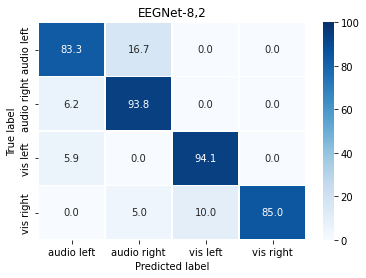

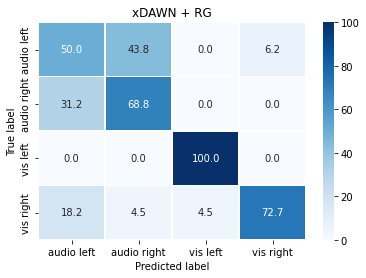

In [ ]:
# plot the confusion matrices for both classifiers
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
plt.figure(figsize = (7,7))
cf_matrix = confusion_matrix(Y_test.argmax(axis = -1), preds)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
ax.set_title('Seaborn Confusion Matrix with labels\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Audio_left', 'Audio_right', 'Visual_left', 'Visual_right'])
ax.yaxis.set_ticklabels(['Audio_left', 'Audio_right', 'Visual_left', 'Visual_right'])

## Display the visualization of the Confusion Matrix.
plt.show()

### **Define paths to model files**

In [ ]:
import os
MODELS_DIR = 'models/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)


In [ ]:
#Defining model name
MODEL_TF = MODELS_DIR + 'model'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'model_no_quant.tflite'
tflite_model_name = "model_tflite"
MODEL_TFLITE = MODELS_DIR + "model.tflite"
MODEL_TFLITE_MICRO = MODELS_DIR + 'model.cc'

**Saving the model**

In [ ]:
model.save(MODEL_TF)

**Preparing features for evaluating models**

In [ ]:
import tensorflow as tf

x_test = tf.convert_to_tensor(X_train,dtype=tf.float32)
print(x_test.shape)
def representative_dataset():
  for i in range(144):
    yield([tf.reshape(x_test[i],(1,60,151,1))])

(144, 60, 151)


### **Convert the model to TFLite without quantization**

In [ ]:
# Convert the model to TFLite without quantization
converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_TF)
model_no_quant_tflite = converter.convert()
open(MODEL_NO_QUANT_TFLITE, "wb").write(model_no_quant_tflite)

12216

### **Convert and save the model with quantization**

In [ ]:
# Convert and save the model with quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce integer only quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]  #TFLITE_BUILTINS
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
# Create and provide a representative dataset
converter.representative_dataset = representative_dataset
model_tflite = converter.convert()
open(MODEL_TFLITE, "wb").write(model_tflite)

8256

In [ ]:
print(X_test.shape)
x_test1 = X_test.astype(np.float32)
print(x_test1.shape)

(71, 60, 151)
(71, 60, 151)


### **TFLite with no Quantization**

In [ ]:
#initialize and allocate memory
no_q_interpreter = tf.lite.Interpreter(model_content=model_no_quant_tflite)
no_q_interpreter.allocate_tensors()

y_test_pred_no_quant_tflite = np.empty([71,4], dtype=np.float32)
success = 0;res_pred = [];res_act = [];

for i in range(len(x_test1)):
  #Input Tensor
  input_shape = no_q_interpreter.get_input_details()[0]['shape'];
  inputtensor = np.array(x_test1[i].reshape(input_shape), dtype=np.float32)
  #Invoking model interpreter
  no_q_interpreter.set_tensor(no_q_interpreter.get_input_details()[0]["index"], inputtensor)
  no_q_interpreter.invoke()
  #Calculating the testing accuracy
  y_test_pred_no_quant_tflite[i] = no_q_interpreter.get_tensor(no_q_interpreter.get_output_details()[0]["index"])[0]
  maxElem = np.amax(y_test_pred_no_quant_tflite[i])
  res1 = np.where(y_test_pred_no_quant_tflite[i] == maxElem)
  maxElem = np.amax(Y_test[i])
  res2 = np.where(Y_test[i] == maxElem)
  res_pred.append(res1[0]+1);
  res_act.append(res2[0]+1);
  if(res1[0] == res2[0]):
    success+=1;

#Displaying the predicted and actual labels
pred = pd.DataFrame(np.reshape(x_test1,(71,60*151)));
pred = pred.assign(Pred_Class1 = y_test_pred_no_quant_tflite[:,0],
                   Pred_Class2 = y_test_pred_no_quant_tflite[:,1],
                   Pred_Class3 = y_test_pred_no_quant_tflite[:,2],
                   Pred_Class4 = y_test_pred_no_quant_tflite[:,3],
                   Predicted_Class = res_pred,
                   Actual_class = res_act);

display(pred);

print("\nClassification Accuracy for non_quantized model = ",(success/len(x_test1)));    

[0.2168254  0.7115437  0.02593151 0.04569944] [1]
[0. 1. 0. 0.] [1]
[0.0205219  0.01910297 0.9312277  0.02914745] [2]
[0. 0. 1. 0.] [2]
[0.55689204 0.1264193  0.22625491 0.09043378] [0]
[1. 0. 0. 0.] [0]
[0.02872921 0.07132661 0.01541379 0.8845304 ] [3]
[0. 0. 0. 1.] [3]
[0.11256393 0.6604397  0.1181263  0.10887009] [1]
[0. 1. 0. 0.] [1]
[0.03176183 0.0148222  0.9175828  0.0358332 ] [2]
[0. 0. 1. 0.] [2]
[0.6249292  0.2439071  0.01647037 0.11469332] [0]
[1. 0. 0. 0.] [0]
[0.01467727 0.9362018  0.02989528 0.01922563] [1]
[0. 1. 0. 0.] [1]
[0.01136822 0.01362455 0.9592025  0.01580461] [2]
[0. 0. 1. 0.] [2]
[0.7705577  0.08027067 0.11808384 0.03108779] [0]
[1. 0. 0. 0.] [0]
[0.11262685 0.05524831 0.12429978 0.7078251 ] [3]
[0. 0. 0. 1.] [3]
[0.30020598 0.44984177 0.0363699  0.21358237] [1]
[0. 1. 0. 0.] [1]
[0.02840637 0.00691668 0.95509773 0.00957925] [2]
[0. 0. 1. 0.] [2]
[0.85187376 0.07649722 0.0547892  0.01683976] [0]
[1. 0. 0. 0.] [0]
[0.02068449 0.01806556 0.08361941 0.8776306 ] [3

**Input Details**

In [ ]:
no_q_interpreter.get_input_details()

[{'name': 'serving_default_input_1:0',
  'index': 0,
  'shape': array([  1,  60, 151,   1], dtype=int32),
  'shape_signature': array([ -1,  60, 151,   1], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

**Output details**

In [ ]:
no_q_interpreter.get_output_details()

[{'name': 'StatefulPartitionedCall:0',
  'index': 20,
  'shape': array([1, 4], dtype=int32),
  'shape_signature': array([-1,  4], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

## **TFLite with Quantization**

**Allocating tensors**

In [ ]:
q_interpreter = tf.lite.Interpreter(model_content=model_tflite)
q_interpreter.allocate_tensors()

**Model input details**

In [ ]:
#interpreter gives us information we'll need to prepare input and output data
q_interpreter.get_input_details()

[{'name': 'serving_default_input_1:0',
  'index': 0,
  'shape': array([  1,  60, 151,   1], dtype=int32),
  'shape_signature': array([ -1,  60, 151,   1], dtype=int32),
  'dtype': numpy.int8,
  'quantization': (0.0008163931197486818, -24),
  'quantization_parameters': {'scales': array([0.00081639], dtype=float32),
   'zero_points': array([-24], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

**Model output details**

In [ ]:
q_interpreter.get_output_details()

[{'name': 'StatefulPartitionedCall:0',
  'index': 20,
  'shape': array([1, 4], dtype=int32),
  'shape_signature': array([-1,  4], dtype=int32),
  'dtype': numpy.int8,
  'quantization': (0.00390625, -128),
  'quantization_parameters': {'scales': array([0.00390625], dtype=float32),
   'zero_points': array([-128], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [ ]:
input_details = q_interpreter.get_input_details()[0]
output_details = q_interpreter.get_output_details()[0]

input_scale, input_zero_point = input_details["quantization"]

x_test_ = x_test1 / input_scale + input_zero_point
display(pd.DataFrame(np.reshape(x_test1,(71,151*60))));
display(pd.DataFrame(np.reshape(x_test_,(71,151*60))));

print(x_test1[3]) 
print(x_test_[3])
x_test_ = x_test_.astype(input_details["dtype"])
display(pd.DataFrame(np.reshape(x_test_,(71,151*60))));

print("\n\n\nQuantized output : \n")
# Invoke the interpreter
y_test_pred_tflite = np.empty([71,4], dtype=output_details["dtype"])
success = 0;
res_pred = [];res_act=[];
for i in range(len(x_test_)):
    #Input tensors
    input_shape= q_interpreter.get_input_details()[0]['shape'];
    inputtensor = np.array(x_test_[i].reshape(input_shape), dtype=np.int8)
    #invoke interpreter
    q_interpreter.set_tensor(input_details["index"], inputtensor)
    q_interpreter.invoke()
    #Calculate test accuracy
    y_test_pred_tflite[i] = q_interpreter.get_tensor(output_details["index"])[0]
    maxElem = np.amax(y_test_pred_tflite[i])
    res1 = np.where(y_test_pred_tflite[i] == maxElem)
    maxElem = np.amax(Y_test[i])
    res2 = np.where(Y_test[i] == maxElem)
    res_pred.append(res1[0]+1);
    res_act.append(res2[0]+1);
    if(res1[0][0] == res2[0][0]):
      success+=1;
  
# If required, dequantized the output layer (from integer to float)
output_scale, output_zero_point = output_details["quantization"]
y_test_pred_tflite = y_test_pred_tflite.astype(np.float32)
y_test_pred_tflite1 = (y_test_pred_tflite - output_zero_point) * output_scale

pred = pd.DataFrame(np.reshape(x_test_,(71,60*151)));
pred = pred.assign(Pred_Class1_q = y_test_pred_tflite[:,0],
                   Pred_Class2_q = y_test_pred_tflite[:,1],
                   Pred_Class3_q = y_test_pred_tflite[:,2],
                   Pred_Class4_q = y_test_pred_tflite[:,3],
                   Pred_Class1 = y_test_pred_tflite1[:,0],
                   Pred_Class2 = y_test_pred_tflite1[:,1],
                   Pred_Class3 = y_test_pred_tflite1[:,2],
                   Pred_Class4 = y_test_pred_tflite1[:,3],                   
                   Predicted_Class = res_pred,
                   Actual_class = res_act);
display(pred);

print("\nClassification Accuracy for Quantized model = ",success/len(x_test_));

,0,1,2,3,4,5,6,7,8,9,...,9050,9051,9052,9053,9054,9055,9056,9057,9058,9059
0,-0.004194,-0.010093,-0.002690,0.006129,0.001920,-0.003861,0.003806,0.013079,0.007205,-0.004015,...,0.003846,0.005853,0.008227,0.009976,0.010733,0.011035,0.011264,0.011276,0.010110,0.006639
1,-0.009148,0.000074,0.005536,0.002669,-0.001757,-0.001108,0.003534,0.008710,0.009906,0.001528,...,-0.000337,0.001757,0.002527,-0.000464,-0.003520,-0.003809,-0.003141,-0.003361,-0.003479,-0.002894
2,0.003523,-0.003579,-0.004180,0.003713,0.004538,-0.003673,-0.006542,-0.001757,-0.001036,-0.005094,...,-0.006786,-0.003386,-0.003664,-0.003788,-0.000702,0.001584,0.000052,-0.000914,0.002233,0.005140
3,-0.006072,-0.011219,-0.009342,0.001391,0.010780,0.011061,0.006249,0.003308,0.003544,0.004578,...,-0.000598,0.001392,0.001735,-0.000227,-0.001615,-0.000902,-0.000208,-0.001314,-0.002220,-0.000696
4,-0.005842,-0.001565,-0.005338,-0.008810,0.000150,0.014113,0.016709,0.008568,0.001217,-0.003970,...,0.000908,0.003237,0.006262,0.006199,0.004143,0.004929,0.008231,0.008506,0.004403,0.000744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,0.005864,-0.004179,-0.001315,0.006821,-0.000653,-0.014626,-0.008492,0.012965,0.017966,0.000361,...,-0.005147,-0.002424,-0.002267,-0.004446,-0.005083,-0.003439,-0.002352,-0.002922,-0.003316,-0.002525
67,0.004587,0.001885,-0.004905,-0.006425,-0.002929,-0.001749,-0.004911,-0.003857,0.007078,0.017092,...,-0.000593,-0.001034,-0.002224,-0.002893,-0.000772,0.003160,0.005563,0.005493,0.004522,0.003104
68,-0.007533,-0.000786,0.005859,0.006119,0.001304,-0.002044,-0.004138,-0.007412,-0.006266,0.002945,...,0.000255,-0.000488,-0.000299,0.001258,0.003975,0.005977,0.004637,-0.000201,-0.004684,-0.004382
69,-0.011000,-0.002675,0.003632,0.006324,0.003787,-0.001937,-0.002754,0.004395,0.010109,0.006383,...,-0.001810,-0.002402,-0.003627,-0.003759,-0.001958,0.000874,0.003127,0.003313,0.001040,-0.001837


,0,1,2,3,4,5,6,7,8,9,...,9050,9051,9052,9053,9054,9055,9056,9057,9058,9059
0,-29.137039,-36.362480,-27.295340,-16.493134,-21.648361,-28.729836,-19.337490,-7.979755,-15.174804,-28.917528,...,-19.289581,-16.831141,-13.923024,-11.780873,-10.853089,-10.483060,-10.202947,-10.188504,-11.616485,-15.867960
1,-35.205406,-23.909374,-17.219456,-20.731228,-26.151718,-25.357119,-19.671129,-13.330683,-11.866022,-22.128363,...,-24.413240,-21.847712,-20.905064,-24.568256,-28.311382,-28.665178,-27.847158,-28.117153,-28.261045,-27.545065
2,-19.685162,-28.383699,-29.120316,-19.451626,-18.440819,-28.498863,-32.012852,-26.152599,-25.268524,-30.239056,...,-32.311855,-28.147625,-28.487989,-28.640150,-24.860331,-22.059273,-23.936913,-25.119083,-21.264309,-17.704199
3,-31.437506,-37.741982,-35.442417,-22.295681,-10.795369,-10.451432,-16.346180,-19.947824,-19.658644,-18.392403,...,-24.732182,-22.295086,-21.874628,-24.277740,-25.977898,-25.104706,-24.254194,-25.609329,-26.719006,-24.852844
4,-31.155977,-25.916651,-30.538074,-34.791191,-23.816345,-6.713240,-3.532871,-13.504597,-22.509642,-28.863323,...,-22.887993,-20.035509,-16.329355,-16.406935,-18.925335,-17.962475,-13.917876,-13.581429,-18.606867,-23.088327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,-16.816681,-29.119293,-25.610407,-15.645281,-24.800394,-41.915642,-34.401466,-8.118751,-1.992933,-23.557362,...,-30.304083,-26.969481,-26.776814,-29.446301,-30.225807,-28.211956,-26.881302,-27.578844,-28.061911,-27.092699
67,-18.381786,-21.690687,-30.007990,-31.869856,-27.587837,-26.142235,-30.015455,-28.724018,-15.329709,-3.063929,...,-24.726116,-25.266510,-26.724190,-27.543428,-24.945576,-20.128887,-17.185829,-17.271118,-18.461475,-20.198460
68,-33.226624,-24.962269,-16.823147,-16.505192,-22.402119,-26.503523,-29.068279,-33.079178,-31.674835,-20.392738,...,-23.688147,-24.597729,-24.365816,-22.458652,-19.130550,-16.678251,-18.320456,-24.246315,-29.737663,-29.366905
69,-37.473419,-27.277040,-19.551641,-16.254246,-19.361628,-26.372822,-27.372875,-18.616150,-11.617200,-16.181297,...,-26.216665,-26.941952,-28.442326,-28.604067,-26.398375,-22.929688,-20.169323,-19.942419,-22.726204,-26.250223


[[-0.00607193 -0.01121886 -0.00934151 ... -0.00844269 -0.00810874
  -0.00596904]
 [ 0.0170495   0.00828338  0.00236239 ... -0.00221763 -0.00264256
  -0.00534579]
 [ 0.01295445  0.00106594  0.00203606 ... -0.00396928 -0.00135212
   0.00162666]
 ...
 [ 0.00867317  0.00394784  0.00386225 ... -0.00086329 -0.0009644
   0.00138182]
 [ 0.00529683  0.00158674  0.00222707 ... -0.00057693 -0.00043765
   0.00192815]
 [ 0.00240439 -0.00024603  0.00130026 ... -0.00131385 -0.00221978
  -0.00069626]]
[[-31.437506  -37.74198   -35.442417  ... -34.341454  -33.9324
  -31.311481 ]
 [ -3.1160698 -13.853685  -21.106306  ... -26.716377  -27.236868
  -30.548061 ]
 [ -8.132089  -22.694328  -21.506035  ... -28.861977  -25.656206
  -22.007502 ]
 ...
 [-13.376234  -19.164291  -19.269133  ... -25.057444  -25.181297
  -22.307407 ]
 [-17.51191   -22.056398  -21.272062  ... -24.706678  -24.536081
  -21.63821  ]
 [-21.054865  -24.301363  -22.407312  ... -25.60933   -26.719006
  -24.852844 ]]


,0,1,2,3,4,5,6,7,8,9,...,9050,9051,9052,9053,9054,9055,9056,9057,9058,9059
0,-29,-36,-27,-16,-21,-28,-19,-7,-15,-28,...,-19,-16,-13,-11,-10,-10,-10,-10,-11,-15
1,-35,-23,-17,-20,-26,-25,-19,-13,-11,-22,...,-24,-21,-20,-24,-28,-28,-27,-28,-28,-27
2,-19,-28,-29,-19,-18,-28,-32,-26,-25,-30,...,-32,-28,-28,-28,-24,-22,-23,-25,-21,-17
3,-31,-37,-35,-22,-10,-10,-16,-19,-19,-18,...,-24,-22,-21,-24,-25,-25,-24,-25,-26,-24
4,-31,-25,-30,-34,-23,-6,-3,-13,-22,-28,...,-22,-20,-16,-16,-18,-17,-13,-13,-18,-23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,-16,-29,-25,-15,-24,-41,-34,-8,-1,-23,...,-30,-26,-26,-29,-30,-28,-26,-27,-28,-27
67,-18,-21,-30,-31,-27,-26,-30,-28,-15,-3,...,-24,-25,-26,-27,-24,-20,-17,-17,-18,-20
68,-33,-24,-16,-16,-22,-26,-29,-33,-31,-20,...,-23,-24,-24,-22,-19,-16,-18,-24,-29,-29
69,-37,-27,-19,-16,-19,-26,-27,-18,-11,-16,...,-26,-26,-28,-28,-26,-22,-20,-19,-22,-26





Quantized output : 

[ -61   44 -122 -116]
[ -61   44 -122 -116] [1]
[0. 1. 0. 0.] [1]
[-123 -123  110 -120]
[-123 -123  110 -120] [2]
[0. 0. 1. 0.] [2]
[  32  -95  -87 -107]
[  32  -95  -87 -107] [0]
[1. 0. 0. 0.] [0]
[-122 -112 -125  102]
[-122 -112 -125  102] [3]
[0. 0. 0. 1.] [3]
[ -92   34 -101  -98]
[ -92   34 -101  -98] [1]
[0. 1. 0. 0.] [1]
[-115 -122   94 -113]
[-115 -122   94 -113] [2]
[0. 0. 1. 0.] [2]
[  31  -64 -124  -98]
[  31  -64 -124  -98] [0]
[1. 0. 0. 0.] [0]
[-124  111 -121 -123]
[-124  111 -121 -123] [1]
[0. 1. 0. 0.] [1]
[-122 -123  109 -120]
[-122 -123  109 -120] [2]
[0. 0. 1. 0.] [2]
[  87 -110 -112 -122]
[  87 -110 -112 -122] [0]
[1. 0. 0. 0.] [0]
[ -99 -114 -105   62]
[ -99 -114 -105   62] [3]
[0. 0. 0. 1.] [3]
[ -45  -22 -120  -69]
[ -45  -22 -120  -69] [1]
[0. 1. 0. 0.] [1]
[-117 -126  112 -125]
[-117 -126  112 -125] [2]
[0. 0. 1. 0.] [2]
[  97 -112 -117 -124]
[  97 -112 -117 -124] [0]
[1. 0. 0. 0.] [0]
[-123 -124 -114  105]
[-123 -124 -114  105] [3]
[0. 

In [ ]:
print(x_test_.shape)
x_test2 = np.reshape(x_test_,(71,60*151));
print(x_test2.shape)

dt = pd.DataFrame(x_test2);
dt[['y1','y2','y3','y4']] = Y_test;
display(dt)
dt.to_csv('quantized_int8_Xtest.csv')

(71, 60, 151)
(71, 9060)


,0,1,2,3,4,5,6,7,8,9,...,9054,9055,9056,9057,9058,9059,y1,y2,y3,y4
0,-29,-36,-27,-16,-21,-28,-19,-7,-15,-28,...,-10,-10,-10,-10,-11,-15,0.0,1.0,0.0,0.0
1,-35,-23,-17,-20,-26,-25,-19,-13,-11,-22,...,-28,-28,-27,-28,-28,-27,0.0,0.0,1.0,0.0
2,-19,-28,-29,-19,-18,-28,-32,-26,-25,-30,...,-24,-22,-23,-25,-21,-17,1.0,0.0,0.0,0.0
3,-31,-37,-35,-22,-10,-10,-16,-19,-19,-18,...,-25,-25,-24,-25,-26,-24,0.0,0.0,0.0,1.0
4,-31,-25,-30,-34,-23,-6,-3,-13,-22,-28,...,-18,-17,-13,-13,-18,-23,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,-16,-29,-25,-15,-24,-41,-34,-8,-1,-23,...,-30,-28,-26,-27,-28,-27,0.0,0.0,0.0,1.0
67,-18,-21,-30,-31,-27,-26,-30,-28,-15,-3,...,-24,-20,-17,-17,-18,-20,0.0,1.0,0.0,0.0
68,-33,-24,-16,-16,-22,-26,-29,-33,-31,-20,...,-19,-16,-18,-24,-29,-29,0.0,0.0,1.0,0.0
69,-37,-27,-19,-16,-19,-26,-27,-18,-11,-16,...,-26,-22,-20,-19,-22,-26,1.0,0.0,0.0,0.0


## **Hex file generation of model files**

In [ ]:
# Another Way of getting the array in .h file
def hex_to_c_array(hex_data, var_name):

  c_str = ''

  # Create header guard
  c_str += '#ifndef ' + var_name.upper() + '_H\n'
  c_str += '#define ' + var_name.upper() + '_H\n\n'

  # Add array length at top of file
  c_str += '\nunsigned int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'

  # Declare C variable
  c_str += 'unsigned char ' + var_name + '[] = {'
  hex_array = []
  for i, val in enumerate(hex_data) :

    # Construct string from hex
    hex_str = format(val, '#04x')

    # Add formatting so each line stays within 80 characters
    if (i + 1) < len(hex_data):
      hex_str += ','
    if (i + 1) % 12 == 0:
      hex_str += '\n '
    hex_array.append(hex_str)

  # Add closing brace
  c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'

  # Close out header guard
  c_str += '#endif //' + var_name.upper() + '_H'

  return c_str

**Getting non-quantized model hex file**

In [ ]:
c_model_name = "model_tflite"
with open(c_model_name + '.h', 'w') as file:
  file.write(hex_to_c_array(model_tflite , c_model_name)) #model_tflite

**Getting quantized model hex file**

In [ ]:
c_model_name = "model_tflite_float"
with open(c_model_name + '.h', 'w') as file:
  file.write(hex_to_c_array(model_no_quant_tflite, c_model_name))